In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install zoofs==0.1.26

  Preparing metadata (setup.py) ... done
  Created wheel for zoofs: filename=zoofs-0.1.26-py3-none-any.whl size=23600 sha256=4f8b391bd3fc4544f01bf49f3c500f71a8ae2d7e3cf562811235433be0299ab1
  Stored in directory: /root/.cache/pip/wheels/c5/47/90/d0547288297679ffb3e38d6d5b700dab7bc0314cf677051b77
Successfully built zoofs


In [ ]:
from zoofs import GreyWolfOptimization

### Imports and Installations

In [3]:
import pandas as pd
import numpy as np
# import scipy as sp
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# import models
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, log_loss, precision_score, recall_score

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# /content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv
# /content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/IDS_mapping.csv

### Load Dataset

In [6]:
df = pd.read_csv('/content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.shape

(101766, 50)

In [ ]:
df.sample(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
65593,182865234,90000675,Caucasian,Male,[50-60),[100-125),3,6,1,3,...,No,No,No,No,No,No,No,No,Yes,NO
21609,75145206,102558681,Caucasian,Female,[70-80),?,1,1,1,3,...,No,No,No,No,No,No,No,No,No,NO


In [ ]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [ ]:
# df_ids_mapping = pd.read_csv('/content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/IDS_mapping.csv')
# df_ids_mapping

### Data Preprocessing

#### Handle missing values

In [ ]:
# let's check unique values of each column
for col in df.columns:
    if df[col].dtype == object:
        print(f"{col} - {df[col].nunique()}   |   {df[col].unique().tolist()}")

race - 6   |   ['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic']
gender - 3   |   ['Female', 'Male', 'Unknown/Invalid']
age - 10   |   ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
weight - 10   |   ['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)', '[125-150)', '[175-200)', '[150-175)', '>200']
payer_code - 18   |   ['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM', 'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR']
medical_specialty - 73   |   ['Pediatrics-Endocrinology', '?', 'InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Gastroenterology', 'Surgery-Cardiovascular/Thoracic', 'Nephrology', 'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma', 'Pulmonology', 'Surgery-Neuro', 'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology', 'Pediatrics', 'Hematology/Oncology', 'Otolaryngology', 'Surgery-Colon&Rectal', 'Pediatric

In [ ]:
# columns which have only one unique values, we will drop these ones as well
for col in df.columns:
    if df[col].dtype == object:
        if df[col].nunique() == 1:
            print(f"{col} - {df[col].nunique()} || {df[col].unique().tolist()}")

examide - 1 || ['No']
citoglipton - 1 || ['No']


In [ ]:
# in this dataset missing values are represented as "?"
print(f"Total no/ of samples in the dataset: {df.shape[0]}")
for col in df.columns:
    if df[col].dtype == object:
        if df[col][df[col] == '?'].any():
            print(f" missing values -  {df[col][df[col] == '?'].count()} :: '{col}' ")

Total no/ of samples in the dataset: 101766
 missing values -  2273 :: 'race' 
 missing values -  98569 :: 'weight' 
 missing values -  40256 :: 'payer_code' 
 missing values -  49949 :: 'medical_specialty' 
 missing values -  21 :: 'diag_1' 
 missing values -  358 :: 'diag_2' 
 missing values -  1423 :: 'diag_3' 


In [ ]:
# let's drop the columns that are not required
columns_with_high_empty_values = ['weight', 'payer_code', 'medical_specialty']
columns_with_only_one_unique_value = ['examide', 'citoglipton']

df = df.drop(columns_with_high_empty_values+ columns_with_only_one_unique_value, axis=1)

In [ ]:
# define conditions where rows should be dropped
condition_all_diag_missing = (df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')
condition_diag_1_missing = (df['diag_1'] == '?')
condition_diag_2_missing = (df['diag_2'] == '?')
condition_diag_3_missing = (df['diag_3'] == '?')
condition_race_missing = (df['race'] == '?')
condition_discharge_disposition_11 = (df['discharge_disposition_id'] == 11)
condition_gender_invalid = (df['gender'] == 'Unknown/Invalid')

# combine all conditions
conditions_to_drop = (
    condition_all_diag_missing |
    condition_diag_1_missing |
    condition_diag_2_missing |
    condition_diag_3_missing |
    condition_race_missing |
    condition_discharge_disposition_11 |
    condition_gender_invalid
)

# get indices to drop
drop_Idx = df.index[conditions_to_drop]

# drop the rows from the dataframe
df = df.drop(index=drop_Idx)

#### Feature Engineering

In [ ]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [ ]:
keys = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
    'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
    'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
    'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide'
]

print(len(keys))

for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

df['numchange'].value_counts()

21


0    70142
1    24922
2     1271
3      106
4        5
Name: numchange, dtype: int64

In [ ]:
# Define the mapping of string values to numerical values
keys_value_mapping = {
    'No': 0,
    'Steady': 1,
    'Up': 1,
    'Down': 1,
}

# Iterate over the keys (columns) and apply the mapping to each column in a loop
for col in keys:
    df[col] = df[col].replace(keys_value_mapping)

Corverting into Binary Classification

In [ ]:
# 'No' - if the patient was not readmitted after the discharge
# '>30' - if the patient was readmitted in more than 30 days (it could be any number of days more than 30 days so can't blame the hospital)
# '<30' - if the patient was readmitted in less than 30 days

df['readmitted'] = df['readmitted'].replace(
    {'NO': 0, '>30': 0, '<30': 1}
)

In [ ]:
# re-encoding admission type, discharge type and admission source into fewer categories

# define the mapping of old admission_type_id values to new ones
admission_type_mapping = {
    2: 1,
    7: 1,
    6: 5,
    8: 5,
}

# Apply the mapping to the 'admission_type_id' column in a single operation
df['admission_type_id'] = df['admission_type_id'].replace(admission_type_mapping)

# Define the mapping of old discharge_disposition_id values to new ones
discharge_disposition_mapping = {
    6: 1,
    8: 1,
    9: 1,
    13: 1,
    3: 2,
    4: 2,
    5: 2,
    14: 2,
    22: 2,
    23: 2,
    24: 2,
    12: 10,
    15: 10,
    16: 10,
    17: 10,
    25: 18,
    26: 18,
}

# Apply the mapping to the 'discharge_disposition_id' column in a single operation
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(discharge_disposition_mapping)


# Define the mapping of old admission_source_id values to new ones
admission_source_mapping = {
    2: 1,
    3: 1,
    5: 4,
    6: 4,
    10: 4,
    22: 4,
    25: 4,
    15: 9,
    17: 9,
    20: 9,
    21: 9,
    13: 11,
    14: 11,
}

# Apply the mapping to the 'admission_source_id' column in a single operation
df['admission_source_id'] = df['admission_source_id'].replace(admission_source_mapping)

In [ ]:
# Apply the mapping to the respective columns in a single operation
df['change'] = df['change'].replace({'Ch': 1, 'No': 0})
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})
df['diabetesMed'] = df['diabetesMed'].replace({'Yes': 1, 'No': 0})

In [ ]:
df['A1Cresult'] = df['A1Cresult'].replace({'>7': 1, '>8': 1, 'Norm': 0, 'None': -99})
df['max_glu_serum'] = df['max_glu_serum'].replace({'>200': 1, '>300': 1, 'Norm': 0, 'None': -99})

In [ ]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0, 10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)

df['age'].value_counts()

8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: age, dtype: int64

In [ ]:
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95} # convert to mid-value
df['age'] = df.age.map(age_dict)

df['age'].value_counts()

75    24815
65    21521
55    16546
85    16223
45     9208
35     3538
95     2594
25     1471
15      466
5        64
Name: age, dtype: int64

In [ ]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')  # patient_nbr = Unique identifier of a patient
df.shape

(67580, 47)

In [ ]:
df['readmitted'].value_counts()

0    61451
1     6129
Name: readmitted, dtype: int64

In [ ]:
# Function to apply transformations on diagnosis columns
def process_diag(diag_series):
    # Copy the original diagnosis data
    level1_diag = diag_series.copy()
    level2_diag = diag_series.copy()

    # Apply the V and E condition, replace with 0
    level1_diag[diag_series.str.contains('V|E', na=False)] = 0
    level2_diag[diag_series.str.contains('V|E', na=False)] = 0

    # Replace '?' with -1
    level1_diag = level1_diag.replace('?', -1)
    level2_diag = level2_diag.replace('?', -1)

    # Change dtype to float
    level1_diag = level1_diag.astype(float)
    level2_diag = level2_diag.astype(float)

    return level1_diag, level2_diag

# Refactored code to use the function for each diagnosis column
df['level1_diag1'], df['level2_diag1'] = process_diag(df['diag_1'])
df['level1_diag2'], df['level2_diag2'] = process_diag(df['diag_2'])
df['level1_diag3'], df['level2_diag3'] = process_diag(df['diag_3'])

In [ ]:
def map_diag_level(level_diag):
    if (390 <= level_diag < 460) or (np.floor(level_diag) == 785):
        return 1
    elif (460 <= level_diag < 520) or (np.floor(level_diag) == 786):
        return 2
    elif (520 <= level_diag < 580) or (np.floor(level_diag) == 787):
        return 3
    elif np.floor(level_diag) == 250:
        return 4
    elif 800 <= level_diag < 1000:
        return 5
    elif 710 <= level_diag < 740:
        return 6
    elif (580 <= level_diag < 630) or (np.floor(level_diag) == 788):
        return 7
    elif 140 <= level_diag < 240:
        return 8
    else:
        return 0

def map_diag2_level(level_diag):
    if 390 <= level_diag < 399:
        return 1
    elif 401 <= level_diag < 415:
        return 2
    elif 415 <= level_diag < 460:
        return 3
    elif np.floor(level_diag) == 785:
        return 4
    elif 460 <= level_diag < 489:
        return 5
    elif 490 <= level_diag < 497:
        return 6
    elif 500 <= level_diag < 520:
        return 7
    elif np.floor(level_diag) == 786:
        return 8
    elif 520 <= level_diag < 530:
        return 9
    elif 530 <= level_diag < 544:
        return 10
    elif 550 <= level_diag < 554:
        return 11
    elif 555 <= level_diag < 580:
        return 12
    elif np.floor(level_diag) == 787:
        return 13
    elif np.floor(level_diag) == 250:
        return 14
    elif 800 <= level_diag < 1000:
        return 15
    elif 710 <= level_diag < 740:
        return 16
    elif 580 <= level_diag < 630:
        return 17
    elif np.floor(level_diag) == 788:
        return 18
    elif 140 <= level_diag < 240:
        return 19
    elif 240 <= level_diag < 280 and np.floor(level_diag) != 250:
        return 20
    elif (680 <= level_diag < 710) or (np.floor(level_diag) == 782):
        return 21
    elif 290 <= level_diag < 320:
        return 22
    else:
        return 0

for col in ['level1_diag1', 'level1_diag2', 'level1_diag3']:
    df[col] = df[col].apply(map_diag_level)

for col in ['level2_diag1', 'level2_diag2', 'level2_diag3']:
    df[col] = df[col].apply(map_diag2_level)

In [ ]:
# total number of medications used by the patient
df['nummed'] = 0
for col in keys:
    df['nummed'] = df['nummed'] + df[col]

df['nummed'].value_counts()

1    29975
0    16267
2    14865
3     5444
4      976
5       49
6        4
Name: nummed, dtype: int64

In [ ]:
# drop individual diagnosis columns that have too granular disease information
# also drop level 2 categorization (which was not comparable with any reference)
# also drop level 1 secondary and tertiary diagnoses
df.drop([
    'diag_1', 'diag_2', 'diag_3',
    'level2_diag1', 'level1_diag2',
    'level2_diag2', 'level1_diag3',
    'level2_diag3'
    ], axis=1, inplace=True
)

In [ ]:
df.shape

(67580, 46)

In [ ]:
# let's check unique values of each column
for col in df.columns:
    if df[col].dtype == object:
        print(f"{col} - {df[col].nunique()}   |   {df[col].unique().tolist()}")

race - 5   |   ['Caucasian', 'AfricanAmerican', 'Other', 'Asian', 'Hispanic']


In [ ]:
race_dummies = pd.get_dummies(df['race'])
df = pd.concat([df, race_dummies], axis=1)
df.shape

(67580, 51)

In [ ]:
df.drop(['race'], inplace=True, axis=1)

In [ ]:
# let's check unique values of each column
for col in df.columns:
    if df[col].dtype == object:
        print(f"{col} - {df[col].nunique()}   |   {df[col].unique().tolist()}")

In [ ]:
# get list of only numeric features
num_col = list(set(list(df._get_numeric_data().columns)) - {'readmitted'})
len(num_col)

49

In [ ]:
# get list of all categorica data
cat_col = list(set(df.columns) - set(num_col))
len(cat_col)

1

In [ ]:
# split into features and target variables
X = df.drop('readmitted', axis=1)
y = df['readmitted']

In [ ]:
# split the dataset into train and test sets
X, X_val, y, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42
)

In [ ]:
X.shape, y.shape

((60822, 49), (60822,))

In [ ]:
def feature_engineering(df, df_test, num_col, cat_col=None):

    df_cat_1hot_final_train = pd.DataFrame()
    df_cat_1hot_final_test = pd.DataFrame()


    # categorical dataset
    if cat_col:
        # df_cat = df.select_dtypes(include=['category'])  # categorical features
        # df_cat_test = df_test.select_dtypes(include=['category'])  # categorical features
        df_cat = df[cat_col]  # categorical features
        df_cat_test = df_test[cat_col]  # categorical features

        print(f"Categorical Features: {df_cat.shape}")
        binarized_dataframes_train = []
        binarized_dataframes_test = []
        for column in df_cat:
            # train data
            encoder = LabelEncoder()
            df_cat_encoded = encoder.fit_transform(df_cat[column])
            oh_encoder = OneHotEncoder()
            df_cat_1hot = oh_encoder.fit_transform(df_cat_encoded.reshape(-1, 1))
            transformed_data = df_cat_1hot.todense()
            column_names = [f"{column}_{cls}" for cls in encoder.classes_]
            print(f"added columns: {column_names}")
            transformed_df = pd.DataFrame(transformed_data, columns=column_names)  # convert back to dataframe
            binarized_dataframes_train.append(transformed_df)

            # test data
            # encoder = LabelEncoder()
            df_cat_encoded = encoder.transform(df_cat_test[column])
            # oh_encoder = OneHotEncoder()
            df_cat_1hot = oh_encoder.transform(df_cat_encoded.reshape(-1, 1))
            transformed_data = df_cat_1hot.todense()
            column_names = [f"{column}_{cls}" for cls in encoder.classes_]
            print(f"added columns: {column_names}")
            transformed_df = pd.DataFrame(transformed_data, columns=column_names)  # convert back to dataframe
            binarized_dataframes_test.append(transformed_df)

        # generate final dataframe of categorical data
        df_cat_1hot_final_train = pd.concat(binarized_dataframes_train, axis=1)
        print(f"Shape of train Categorical dataframe after OneHotEncoding: {df_cat_1hot_final_train.shape}")

        df_cat_1hot_final_test = pd.concat(binarized_dataframes_test, axis=1)
        print(f"Shape of test Categorical dataframe after OneHotEncoding: {df_cat_1hot_final_test.shape}")

    # numerical dataset
    # train
    # df_num = df.select_dtypes(include=['int64', 'float64'])  # numerical features
    df_num = df[num_col]  # numerical features

    std_scaler = StandardScaler()
    df_num_tr = std_scaler.fit_transform(df_num)
    df_num_final = pd.DataFrame(df_num_tr, columns=df_num.columns)
    print(f"train Numerical Features dataframe shape: {df_num_tr.shape}")

    # test
    # df_num_test = df_test.select_dtypes(include=['int64', 'float64'])  # numerical features
    df_num_test = df_test[num_col]  # numerical features

    # std_scaler = StandardScaler()
    df_num_test = std_scaler.transform(df_num_test)
    df_num_final_test = pd.DataFrame(df_num_test, columns=df_num.columns)
    print(f"test Numerical Features dataframe shape: {df_num_test.shape}")

    # concatenate numerical and categorical datasets
    df_final_train = pd.concat([df_num_final, df_cat_1hot_final_train], axis=1)
    df_final_test = pd.concat([df_num_final_test, df_cat_1hot_final_test], axis=1)

    return df_final_train, df_final_test

In [ ]:
X, X_val = feature_engineering(X, X_val, num_col)

train Numerical Features dataframe shape: (60822, 49)
test Numerical Features dataframe shape: (6758, 49)


In [ ]:
X.shape, y.shape

((60822, 49), (60822,))

#### SMOTE

In [ ]:
df['readmitted'].value_counts()

0    61451
1     6129
Name: readmitted, dtype: int64

In [ ]:
df_X, df_y = [], [] # collect resampled dataframe
# apply SMOTE on raw data n times
n = 1
for i in range(n):
    smote = SMOTE() # sampling_strategy=0.1 , k_neighbors=k
    X_resampled, y_resampled = smote.fit_resample(X, y)
    df_X.append(X_resampled)
    df_y.append(y_resampled)

X_resampled = pd.concat(df_X, axis=0)
y_resampled = pd.concat(df_y, axis=0)

In [ ]:
X_resampled.shape, y_resampled.shape

((110548, 49), (110548,))

In [ ]:
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
df_resampled.shape

(110548, 50)

In [ ]:
df_resampled['readmitted'].value_counts()

0    55274
1    55274
Name: readmitted, dtype: int64

In [ ]:
# split into features and target variables
X_rs = df_resampled.drop('readmitted', axis=1)
y_rs = df_resampled['readmitted']
X_rs.shape, y_rs.shape

((110548, 49), (110548,))

#### Feature Selection

In [129]:
def objective_function_topass(model, X_train, y_train, X_valid, y_valid):
    print(X_train.columns)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)
    P = log_loss(y_valid, y_pred)
    return P

# create object of algorithm
algo_object = GreyWolfOptimization(
    objective_function_topass,
    n_iteration=10,
)

rf_model = RandomForestClassifier()
algo_object.fit(rf_model, X_rs, y_rs, X_val, y_val, verbose=True)


selected_features = algo_object.best_feature_list
print(f"Selected Features - {len(selected_features)}: {selected_features}")

Selected Features - 45: ['admission_source_id', 'tolbutamide', 'troglitazone', 'number_emergency', 'Asian', 'numchange', 'admission_type_id', 'number_outpatient', 'AfricanAmerican', 'Hispanic', 'discharge_disposition_id', 'A1Cresult', 'rosiglitazone', 'acarbose', 'change', 'age', 'repaglinide', 'nummed', 'level1_diag1', 'glipizide-metformin', 'service_utilization', 'miglitol', 'tolazamide', 'glimepiride-pioglitazone', 'gender', 'acetohexamide', 'pioglitazone', 'max_glu_serum', 'glyburide', 'nateglinide', 'glyburide-metformin', 'glipizide', 'num_procedures', 'encounter_id', 'time_in_hospital', 'num_medications', 'metformin-pioglitazone', 'number_diagnoses', 'num_lab_procedures', 'Caucasian', 'patient_nbr', 'number_inpatient', 'metformin-rosiglitazone', 'insulin', 'glimepiride']


### Model Training and Prediction

#### With SMOTE + StratifiedKFold + GreyWolf Algorithm

In [ ]:
# selected_features = ['admission_source_id', 'tolbutamide', 'troglitazone', 'number_emergency', 'Asian', 'numchange', 'admission_type_id', 'number_outpatient', 'AfricanAmerican', 'Hispanic', 'discharge_disposition_id', 'A1Cresult', 'rosiglitazone', 'acarbose', 'change', 'age', 'repaglinide', 'nummed', 'level1_diag1', 'glipizide-metformin', 'service_utilization', 'miglitol', 'tolazamide', 'glimepiride-pioglitazone', 'gender', 'acetohexamide', 'pioglitazone', 'max_glu_serum', 'glyburide', 'nateglinide', 'glyburide-metformin', 'glipizide', 'num_procedures', 'encounter_id', 'time_in_hospital', 'num_medications', 'metformin-pioglitazone', 'number_diagnoses', 'num_lab_procedures', 'Caucasian', 'patient_nbr', 'number_inpatient', 'metformin-rosiglitazone', 'insulin', 'glimepiride']

In [ ]:
X_train_ft, X_test_ft = X_rs[selected_features], X_val[selected_features]

In [99]:
# initialize the models
models = {
    'MLP': MLPClassifier(max_iter=1000),
    'XGBoost Classifier': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM Linear Kernel': SVC(kernel='linear', probability=True),
    'SVM RBF Kernel': SVC(kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier()
}

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store cumulative metrics across folds
cumulative_metrics = {name: {'F1': [], 'False Negative': [], 'Accuracy': [], 'Confusion Matrix': [], 'Precision Score': [], 'Recall Score': []} for name, _ in models.items()}

# Train and evaluate each model using cross-validation
for train_index, test_index in skf.split(X_train_ft, y_rs):
    print(f"----------")
    # Create folds
    X_train, X_test = X_train_ft.iloc[train_index], X_train_ft.iloc[test_index]
    y_train, y_test = y_rs.iloc[train_index], y_rs.iloc[test_index]

    for name, model in models.items():
        print(f'Training Model: {name}')

        # Create a pipeline (uncomment or add steps as necessary)
        pipeline = imbPipeline(steps=[('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        fn = cm.sum(axis=1) - np.diag(cm)  # False negatives for each class
        ps = precision_score(y_test, y_pred, average='weighted')
        rs = recall_score(y_test, y_pred, average='weighted')

        # Store the metrics
        cumulative_metrics[name]['F1'].append(f1)
        cumulative_metrics[name]['False Negative'].append(fn)
        cumulative_metrics[name]['Accuracy'].append(acc)
        cumulative_metrics[name]['Confusion Matrix'].append(cm)
        cumulative_metrics[name]['Precision Score'].append(ps)
        cumulative_metrics[name]['Recall Score'].append(rs)

# Calculate and store the average metrics across all folds
performance_df = pd.DataFrame([
    {
        'Model': name,
        'F1': np.mean(metrics['F1']),
        'Accuracy': np.mean(metrics['Accuracy']),
        'Precision Score': np.mean(metrics['Precision Score']),
        'Recall Score': np.mean(metrics['Recall Score']),
        'False Negatives': np.sum(metrics['False Negative'], axis=0)
    }
    for name, metrics in cumulative_metrics.items()
])

performance_df

----------
Training Model: MLP
Training Model: XGBoost Classifier
Training Model: Decision Tree
Training Model: Random Forest
Training Model: Logistic Regression
Training Model: SVM Linear Kernel
Training Model: SVM RBF Kernel
Training Model: KNN
Training Model: Naive Bayes
Training Model: AdaBoost
----------
Training Model: MLP
Training Model: XGBoost Classifier
Training Model: Decision Tree
Training Model: Random Forest
Training Model: Logistic Regression
Training Model: SVM Linear Kernel
Training Model: SVM RBF Kernel
Training Model: KNN
Training Model: Naive Bayes
Training Model: AdaBoost
----------
Training Model: MLP
Training Model: XGBoost Classifier
Training Model: Decision Tree
Training Model: Random Forest
Training Model: Logistic Regression
Training Model: SVM Linear Kernel
Training Model: SVM RBF Kernel
Training Model: KNN
Training Model: Naive Bayes
Training Model: AdaBoost
----------
Training Model: MLP
Training Model: XGBoost Classifier
Training Model: Decision Tree
Trai

,Model,F1,Accuracy,Precision Score,Recall Score,False Negatives
0,MLP,0.812662,0.812697,0.812929,0.812697,"[10495, 10211]"
1,XGBoost Classifier,0.947190,0.947326,0.951977,0.947326,"[109, 5714]"
2,Decision Tree,0.897182,0.897194,0.897384,0.897194,"[6268, 5097]"
3,Random Forest,0.952950,0.953043,0.956655,0.953043,"[139, 5052]"
4,Logistic Regression,0.585640,0.585655,0.585668,0.585655,"[22613, 23192]"
5,SVM Linear Kernel,0.587441,0.588143,0.588747,0.588143,"[25042, 20488]"
6,SVM RBF Kernel,0.773842,0.774297,0.776521,0.774297,"[14952, 9999]"
7,KNN,0.817277,0.822792,0.867089,0.822792,"[19395, 195]"
8,Naive Bayes,0.337299,0.500805,0.562063,0.500805,"[55048, 137]"
9,AdaBoost,0.877085,0.878017,0.889915,0.878017,"[1941, 11544]"


In [108]:
# save the results
performance_df.to_csv('/content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/results_model_comparison.csv', index=False)

In [117]:
# save cumulative_metrics
dict_save_path = '/content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/cumulative_metrics.pkl'

with open(dict_save_path, 'wb') as outfile:
    pickle.dump(cumulative_metrics, outfile)

### Results

In [7]:
# # load the saved results
# performance_df = pd.read_csv('/content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/results_model_comparison.csv')

In [10]:
# dict_save_path = '/content/drive/MyDrive/ACCOUNT-CREATOR/diabetes+130-us+hospitals+for+years+1999-2008/cumulative_metrics.pkl'

# with open(dict_save_path, 'rb') as infile:
#     loaded_metrics_data = pickle.load(infile)

# # loaded_metrics_data

In [2]:
# cumulative_metrics

In [8]:
performance_df

,Model,F1,Accuracy,Precision Score,Recall Score,False Negatives
0,MLP,0.812662,0.812697,0.812929,0.812697,[10495 10211]
1,XGBoost Classifier,0.947190,0.947326,0.951977,0.947326,[ 109 5714]
2,Decision Tree,0.897182,0.897194,0.897384,0.897194,[6268 5097]
3,Random Forest,0.952950,0.953043,0.956655,0.953043,[ 139 5052]
4,Logistic Regression,0.585640,0.585655,0.585668,0.585655,[22613 23192]
5,SVM Linear Kernel,0.587441,0.588143,0.588747,0.588143,[25042 20488]
6,SVM RBF Kernel,0.773842,0.774297,0.776521,0.774297,[14952 9999]
7,KNN,0.817277,0.822792,0.867089,0.822792,[19395 195]
8,Naive Bayes,0.337299,0.500805,0.562063,0.500805,[55048 137]
9,AdaBoost,0.877085,0.878017,0.889915,0.878017,[ 1941 11544]


In [100]:
df = performance_df.copy()
df.drop(columns=['False Negatives'], inplace=True)
df.set_index('Model', inplace=True)
df

,F1,Accuracy,Precision Score,Recall Score
Model,,,,
MLP,0.812662,0.812697,0.812929,0.812697
XGBoost Classifier,0.947190,0.947326,0.951977,0.947326
Decision Tree,0.897182,0.897194,0.897384,0.897194
Random Forest,0.952950,0.953043,0.956655,0.953043
Logistic Regression,0.585640,0.585655,0.585668,0.585655
SVM Linear Kernel,0.587441,0.588143,0.588747,0.588143
SVM RBF Kernel,0.773842,0.774297,0.776521,0.774297
KNN,0.817277,0.822792,0.867089,0.822792
Naive Bayes,0.337299,0.500805,0.562063,0.500805


##### Result Table

In [101]:
df.style.background_gradient(cmap='Blues')

,F1,Accuracy,Precision Score,Recall Score
Model,,,,
MLP,0.812662,0.812697,0.812929,0.812697
XGBoost Classifier,0.947190,0.947326,0.951977,0.947326
Decision Tree,0.897182,0.897194,0.897384,0.897194
Random Forest,0.952950,0.953043,0.956655,0.953043
Logistic Regression,0.585640,0.585655,0.585668,0.585655
SVM Linear Kernel,0.587441,0.588143,0.588747,0.588143
SVM RBF Kernel,0.773842,0.774297,0.776521,0.774297
KNN,0.817277,0.822792,0.867089,0.822792
Naive Bayes,0.337299,0.500805,0.562063,0.500805


##### All Metrics vs All Models

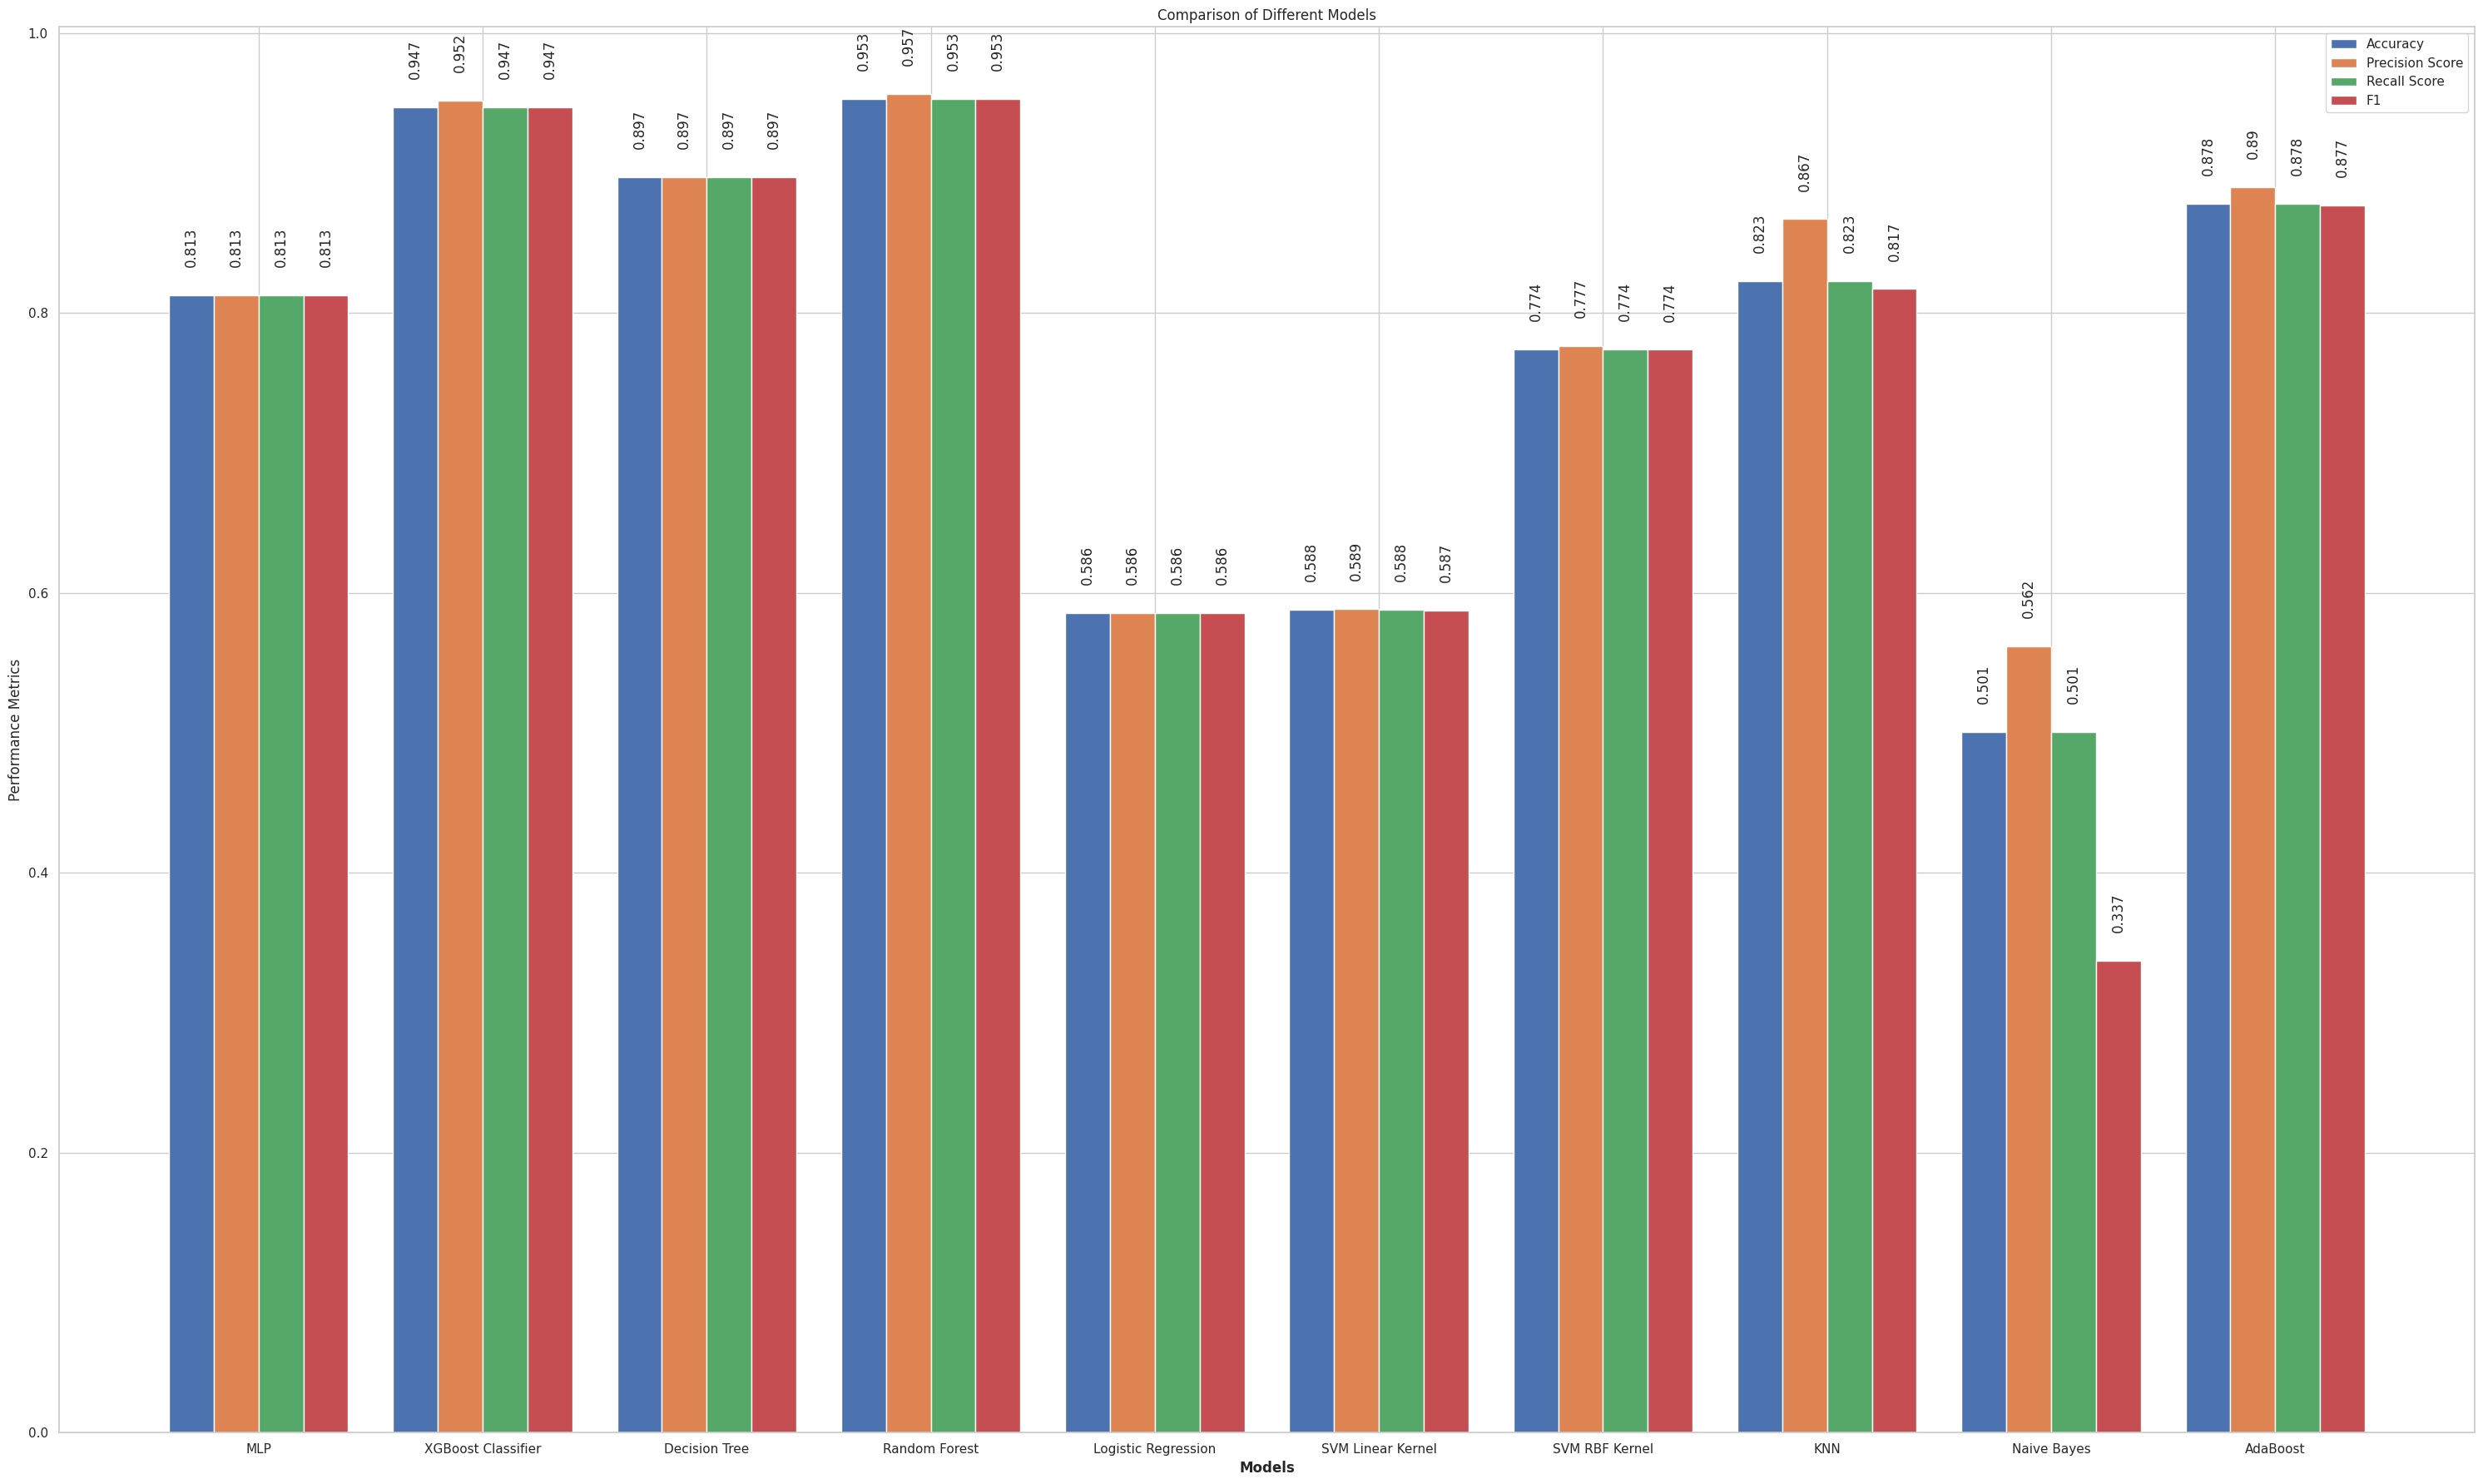

In [102]:
plt.figure(figsize=(30, 18))
barWidth = 0.2
model_index = np.arange(len(performance_df))

# Create bars for each metric
for idx, metric in enumerate(['Accuracy', 'Precision Score', 'Recall Score', 'F1']):
    bars = plt.bar(model_index + barWidth * idx, performance_df[metric], width=barWidth, label=metric)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom', rotation='vertical')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Performance Metrics')
plt.xticks(model_index + barWidth + barWidth / 2, performance_df['Model'])

plt.title('Comparison of Different Models')
plt.legend()

plt.tight_layout()
plt.show()

##### All Models vs Each Metric

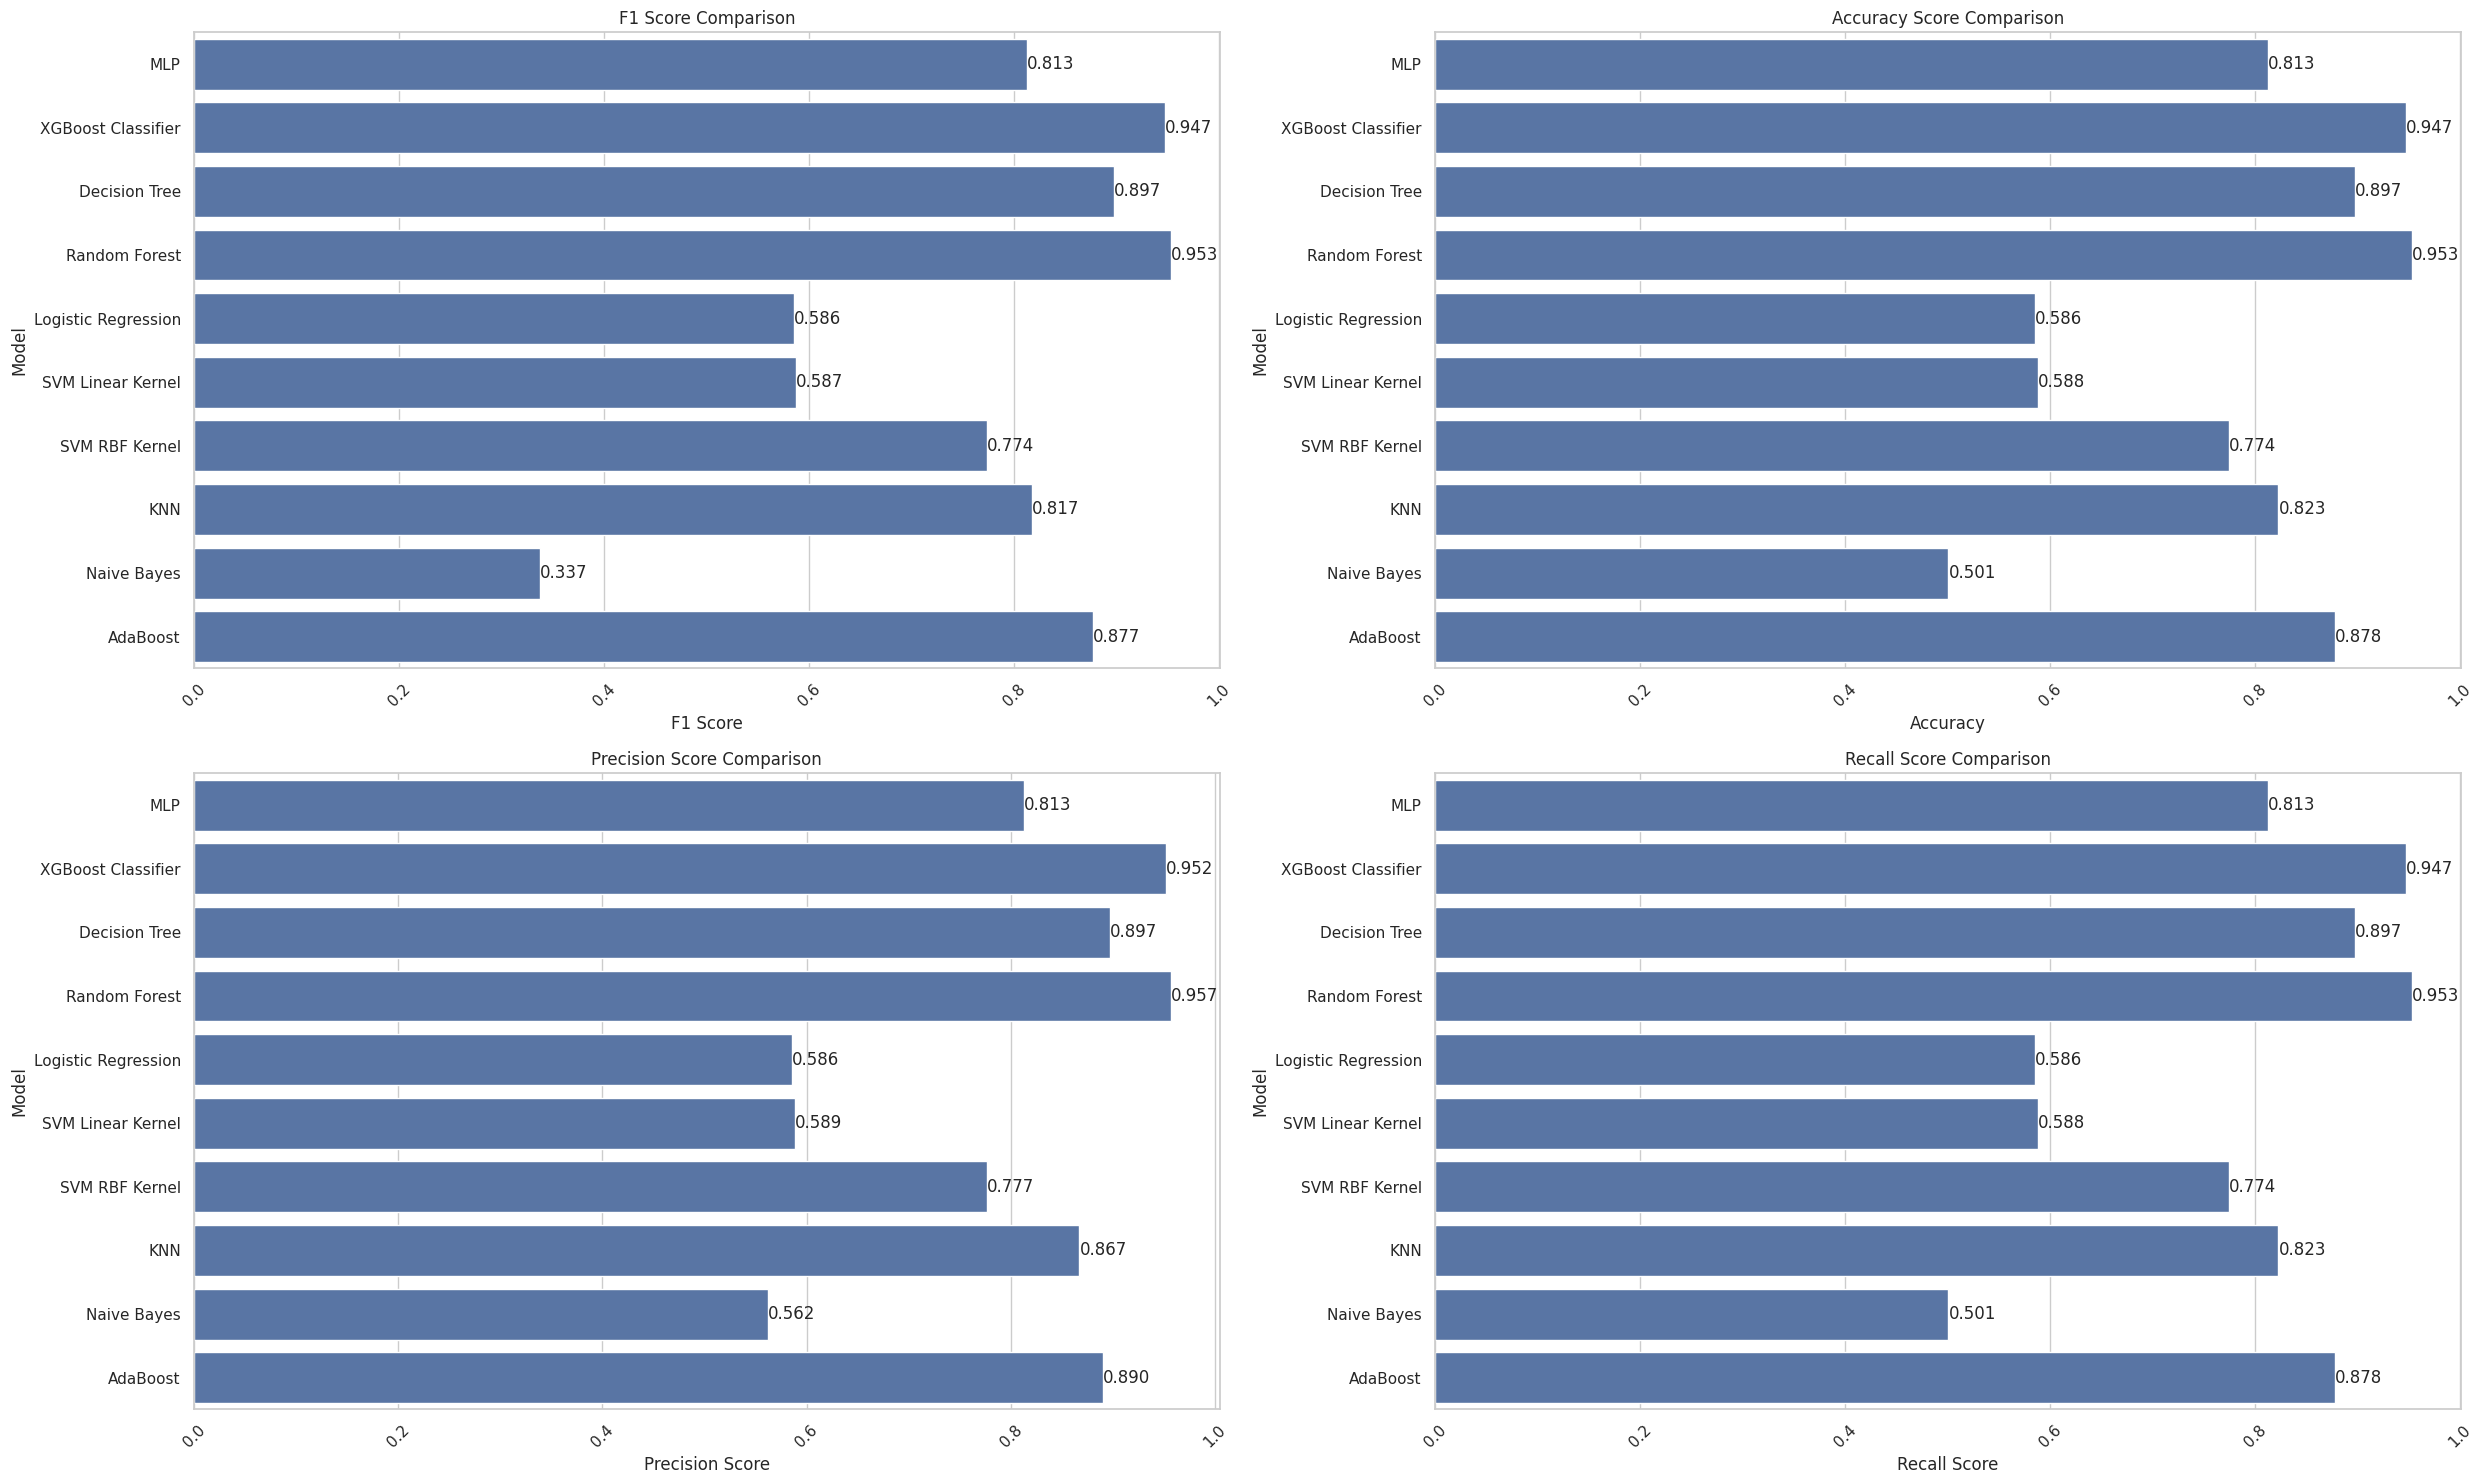

In [125]:
sns.set(style="whitegrid")
f, axes = plt.subplots(2, 2, figsize=(25, 15))

metrics_to_plot = ['F1', 'Accuracy', 'Precision Score', 'Recall Score']
titles = ['F1 Score Comparison', 'Accuracy Score Comparison', 'Precision Score Comparison', 'Recall Score Comparison']

# Loop through the metrics and their respective axes
for i, (metric, ax) in enumerate(zip(metrics_to_plot, axes.flatten())):
    barplot = sns.barplot(x=metric, y='Model', data=performance_df, ax=ax)
    ax.set_title(titles[i])

    for bar in barplot.patches:
        value = bar.get_width()
        text = f'{value:.3f}'
        ax.text(value, bar.get_y() + bar.get_height() / 2, text, va='center')

axes[0, 0].set_xlabel('F1 Score')
axes[0, 1].set_xlabel('Accuracy')
axes[1, 0].set_xlabel('Precision Score')
axes[1, 1].set_xlabel('Recall Score')

for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

#### Metrics vs Fold for Each Model

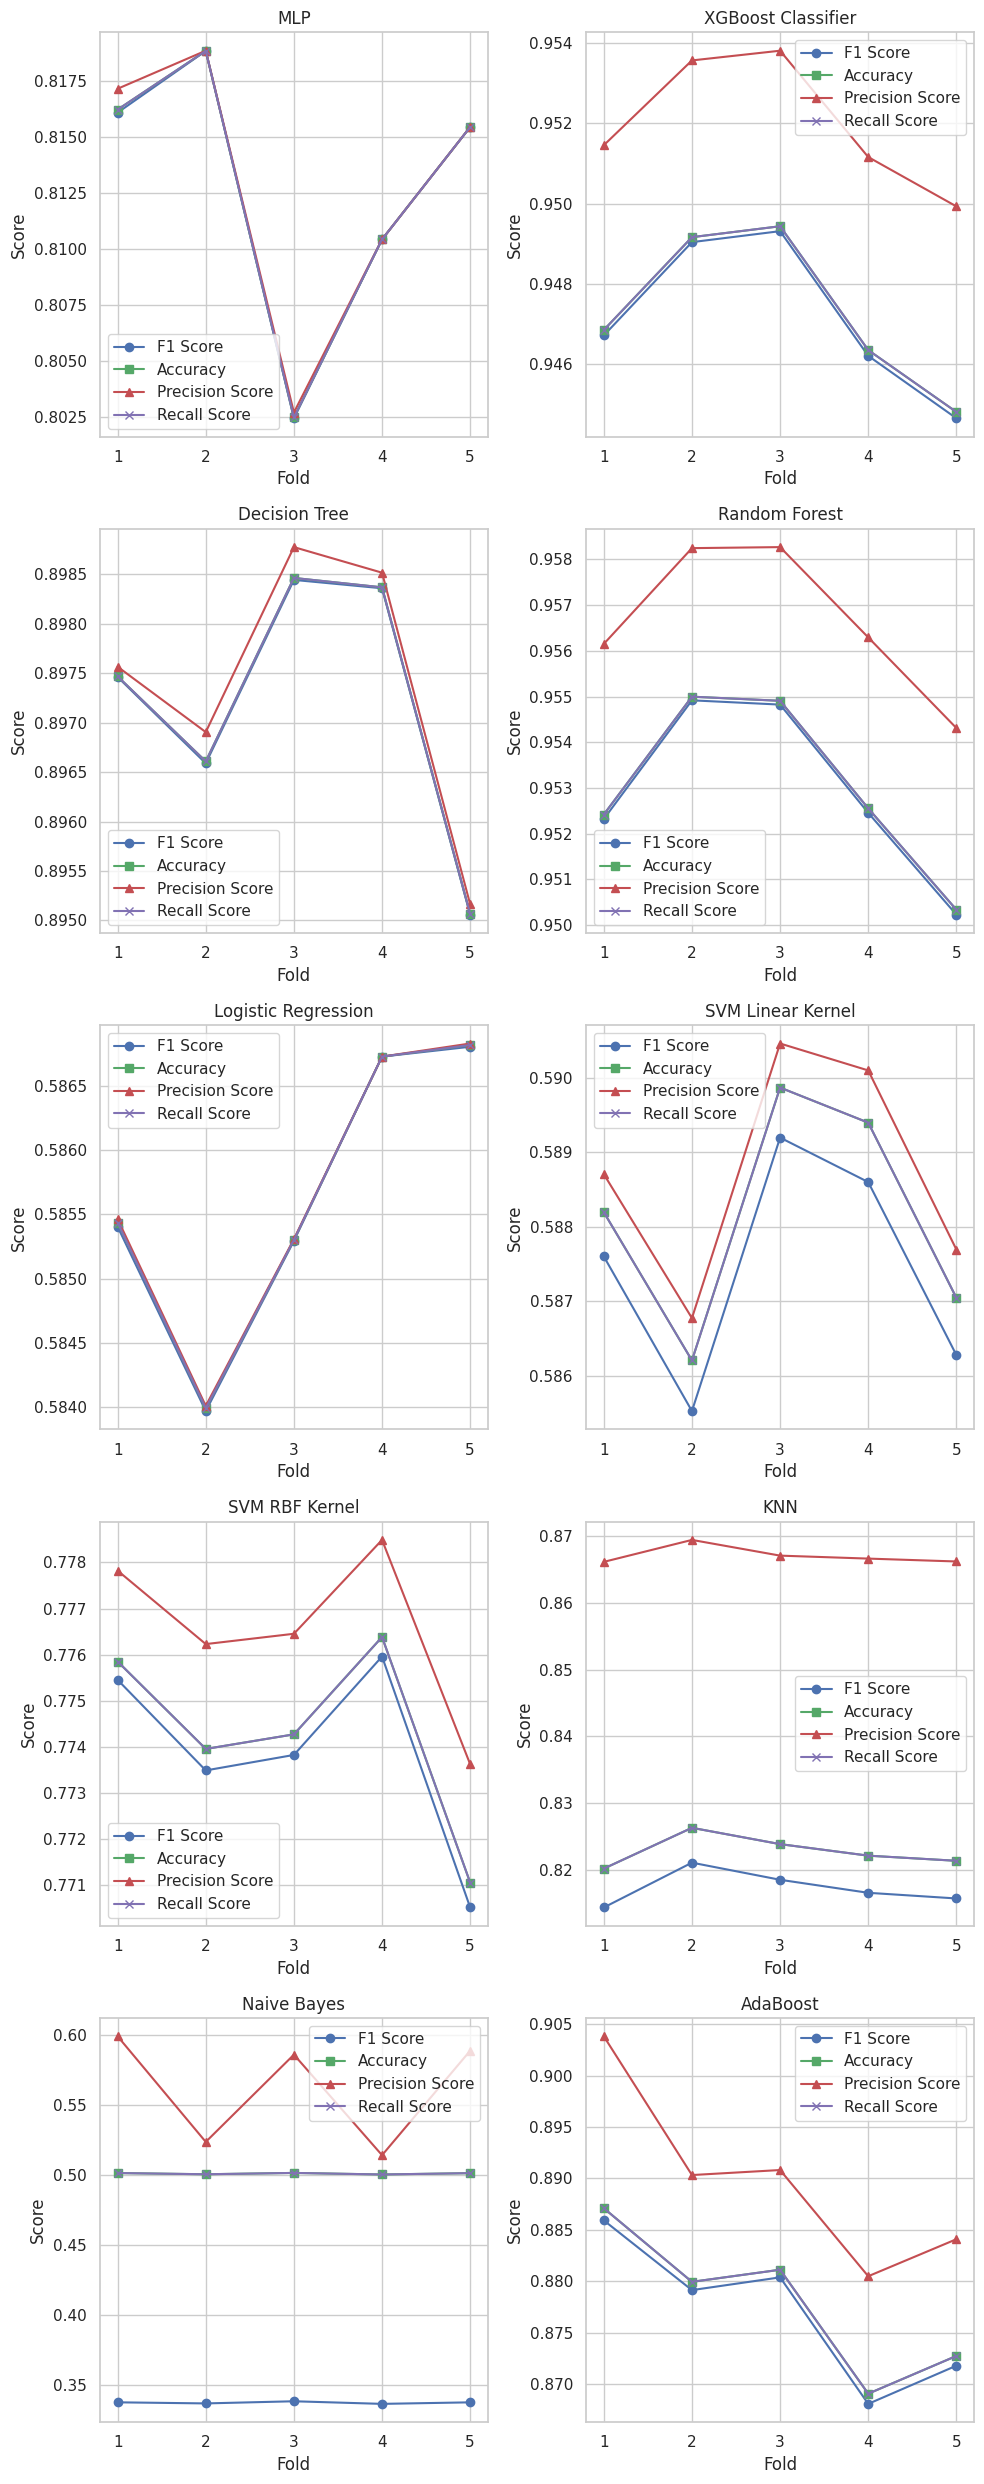

In [115]:
def plot_metrics_per_split(cumulative_metrics, n_splits):
    ncols = 2
    nrows = int(np.ceil(len(cumulative_metrics) / ncols))
    fig_width = ncols * 5
    fig_height = nrows * 5

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
    sns.set_style("whitegrid")

    # Loop over each model and create a plot for the cumulative metrics
    for i, (name, metrics) in enumerate(cumulative_metrics.items()):
        row = i // ncols
        col = i % ncols
        ax = axes[row, col]

        x_ticks = np.arange(1, n_splits + 1)
        ax.plot(x_ticks, metrics['F1'], label='F1 Score', color='b', marker='o')
        ax.plot(x_ticks, metrics['Accuracy'], label='Accuracy', color='g', marker='s')
        ax.plot(x_ticks, metrics['Precision Score'], label='Precision Score', color='r', marker='^')
        ax.plot(x_ticks, metrics['Recall Score'], label='Recall Score', color='m', marker='x')

        ax.set_title(f'{name}')
        ax.set_xlabel('Fold')
        ax.set_ylabel('Score')
        ax.set_xticks(x_ticks)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_metrics_per_split(cumulative_metrics, n_splits)

#### Model vs Metric

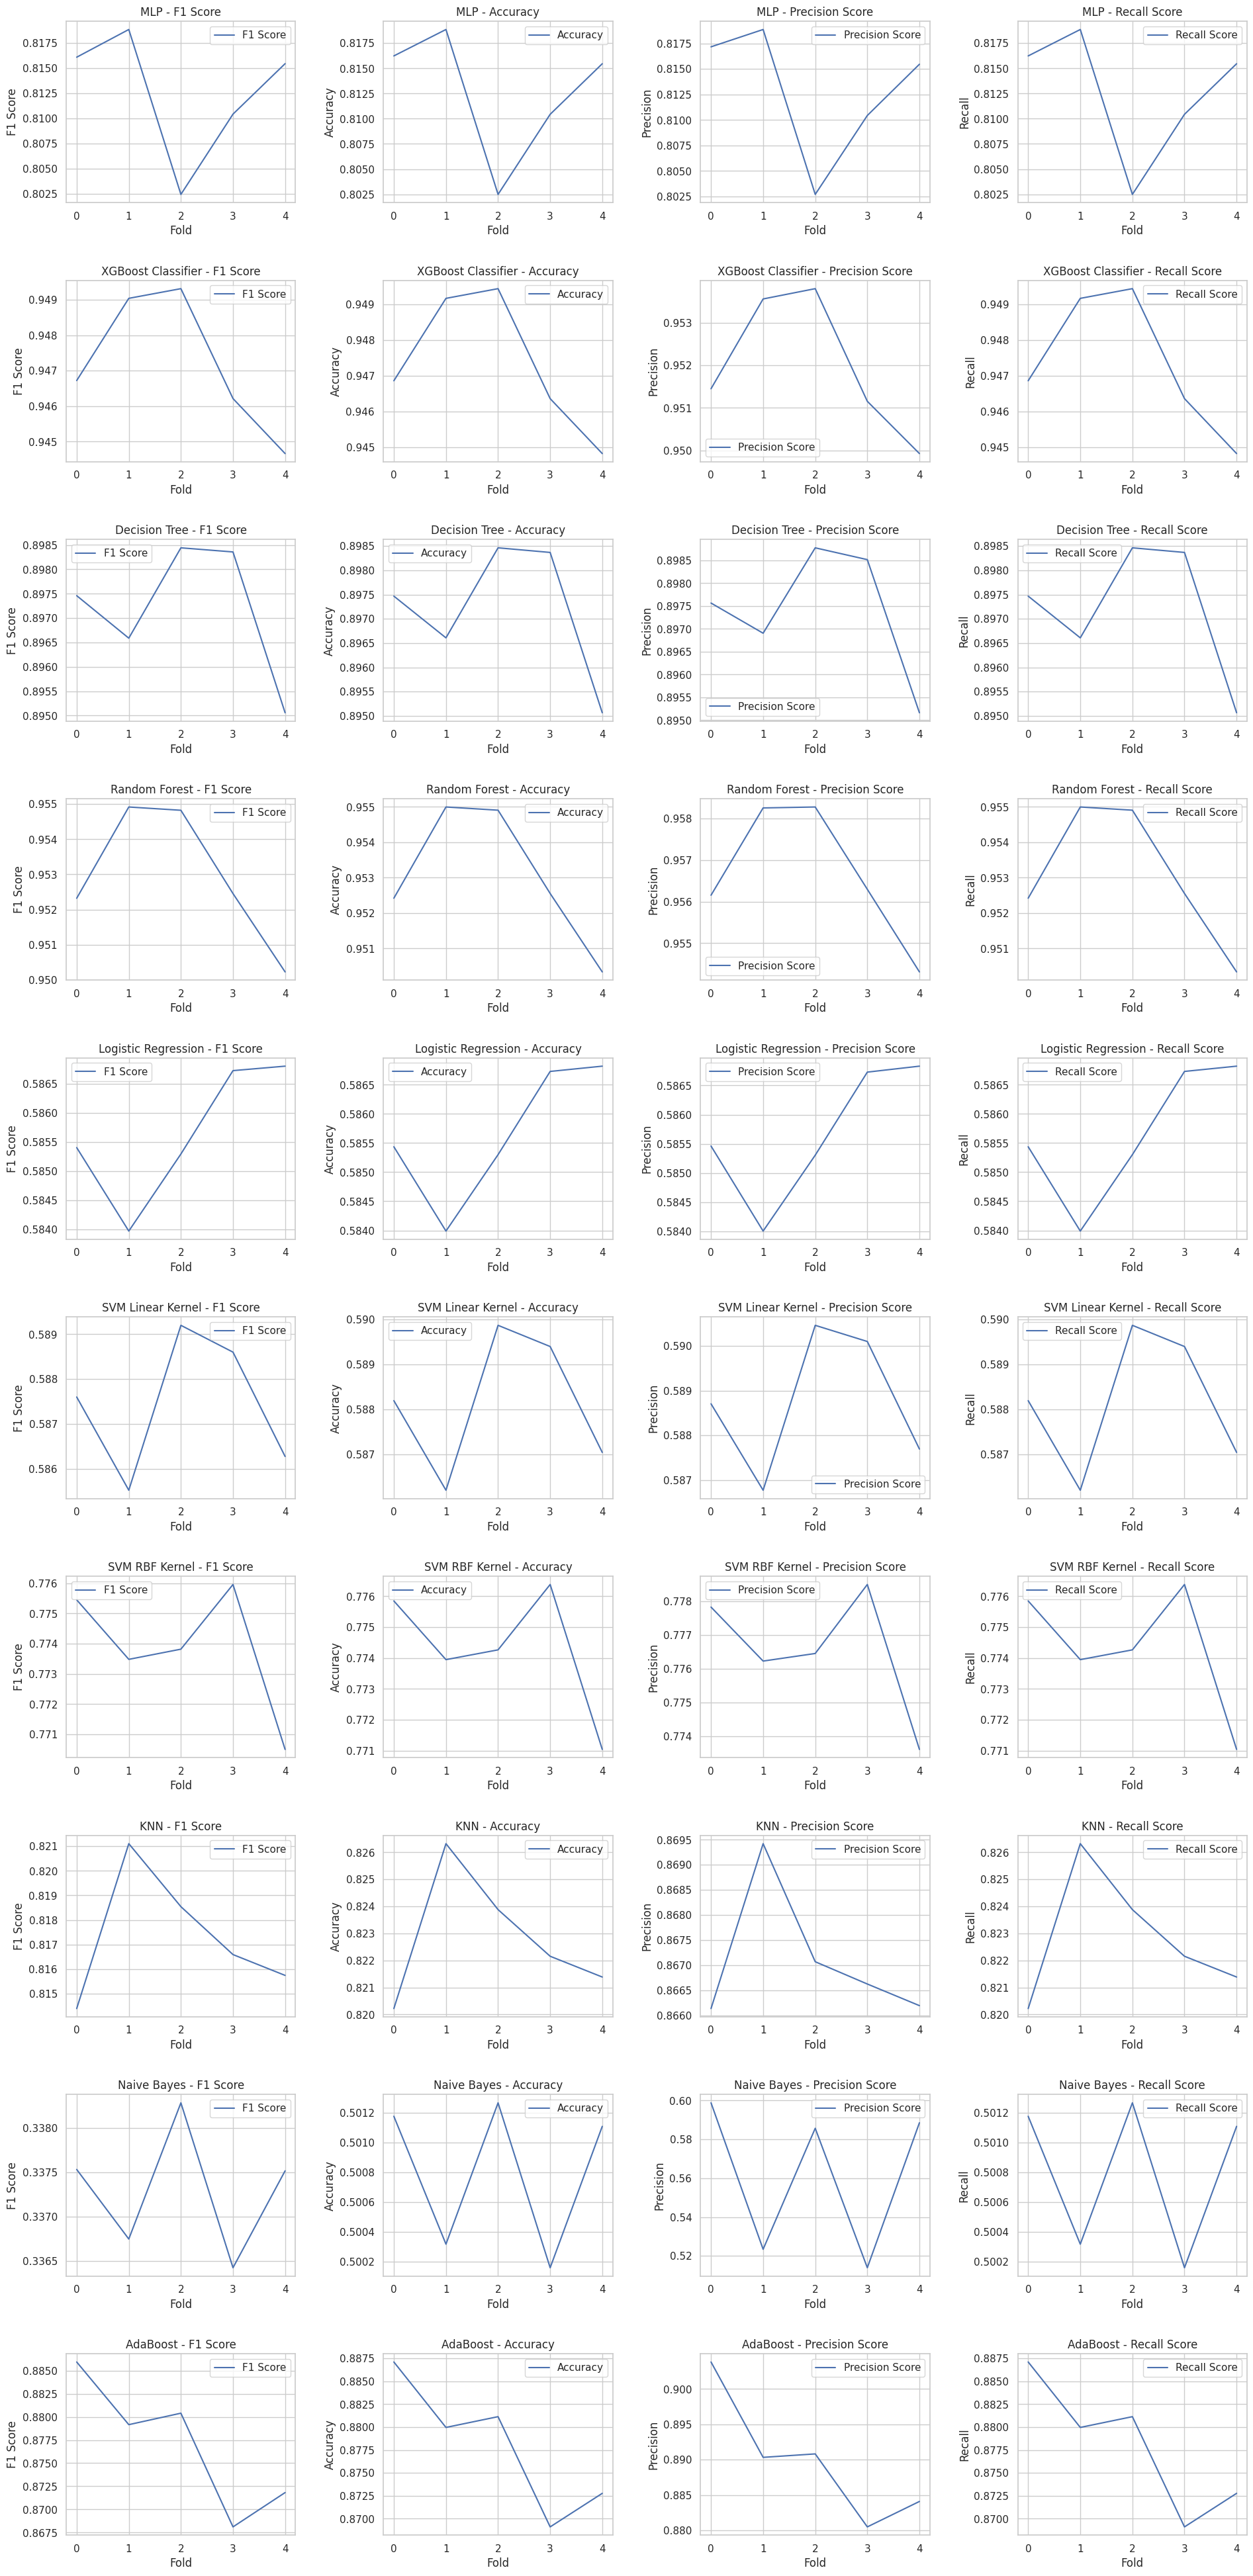

In [121]:
def plot_cumulative_metrics_separately(cumulative_metrics):
    fig, axes = plt.subplots(nrows=len(cumulative_metrics), ncols=4, figsize=(20, len(cumulative_metrics)*4))
    fig.tight_layout(pad=5.0)

    for i, (name, metrics) in enumerate(cumulative_metrics.items()):
        axes[i, 0].plot(metrics['F1'], label='F1 Score')
        axes[i, 0].set_title(f'{name} - F1 Score')
        axes[i, 0].set_xlabel('Fold')
        axes[i, 0].set_ylabel('F1 Score')
        axes[i, 0].legend()

        axes[i, 1].plot(metrics['Accuracy'], label='Accuracy')
        axes[i, 1].set_title(f'{name} - Accuracy')
        axes[i, 1].set_xlabel('Fold')
        axes[i, 1].set_ylabel('Accuracy')
        axes[i, 1].legend()

        axes[i, 2].plot(metrics['Precision Score'], label='Precision Score')
        axes[i, 2].set_title(f'{name} - Precision Score')
        axes[i, 2].set_xlabel('Fold')
        axes[i, 2].set_ylabel('Precision')
        axes[i, 2].legend()

        axes[i, 3].plot(metrics['Recall Score'], label='Recall Score')
        axes[i, 3].set_title(f'{name} - Recall Score')
        axes[i, 3].set_xlabel('Fold')
        axes[i, 3].set_ylabel('Recall')
        axes[i, 3].legend()

    plt.show()

plot_cumulative_metrics_separately(cumulative_metrics)

#### Confusion Matrix for Each Model

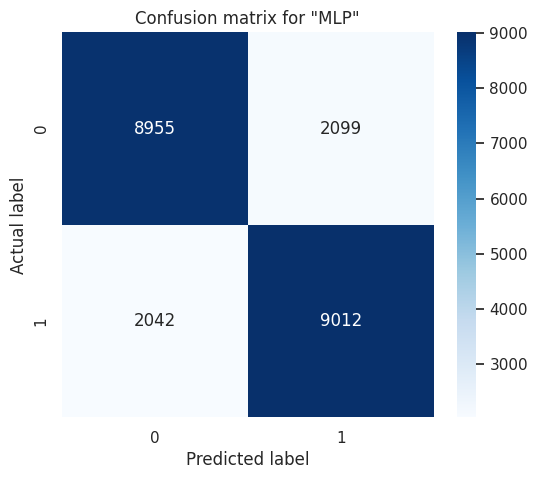

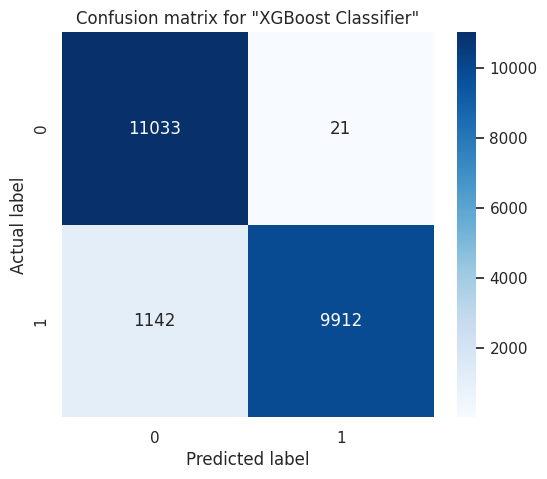

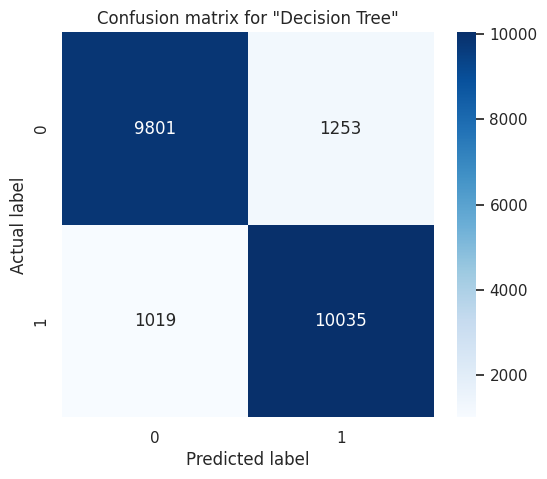

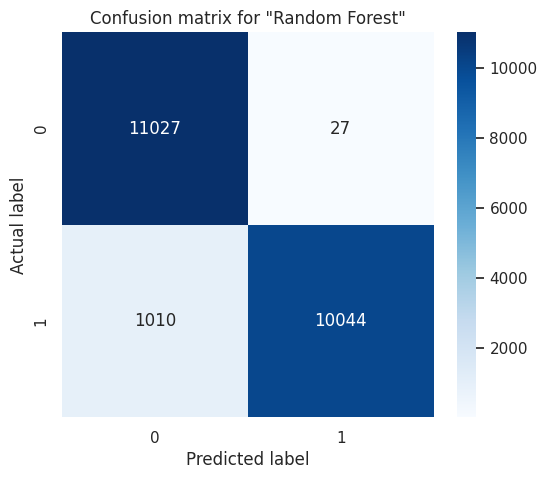

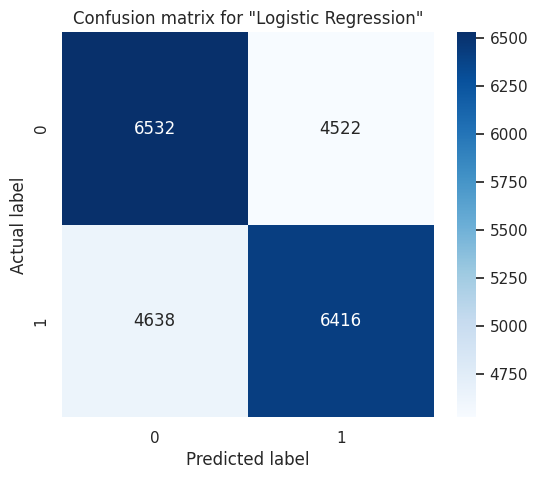

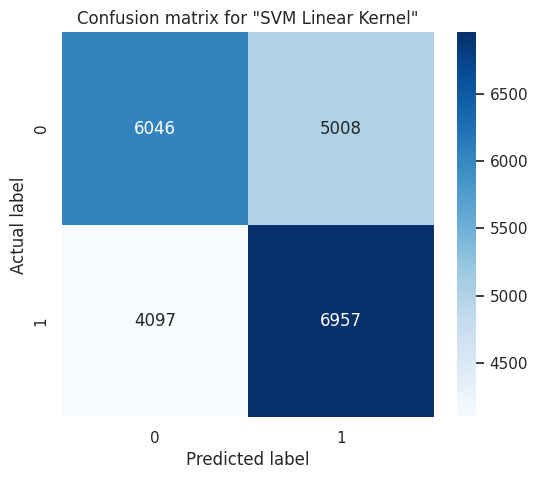

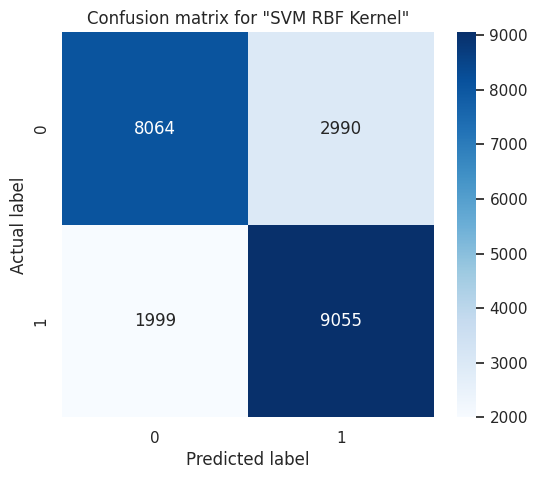

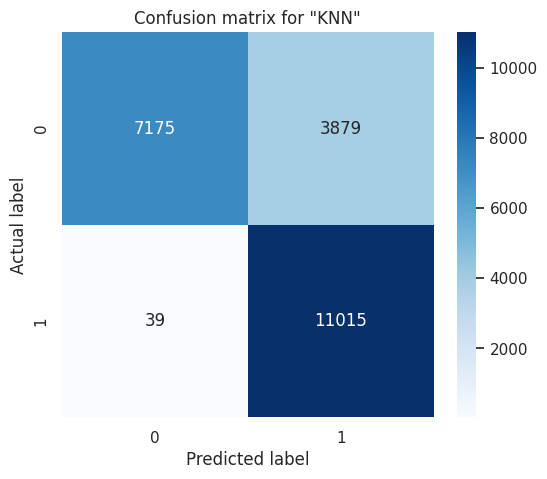

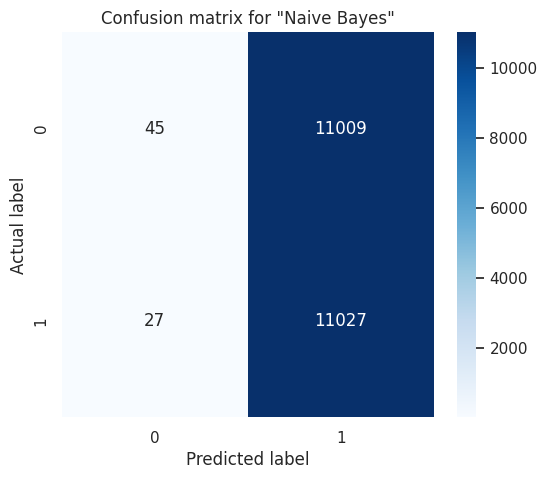

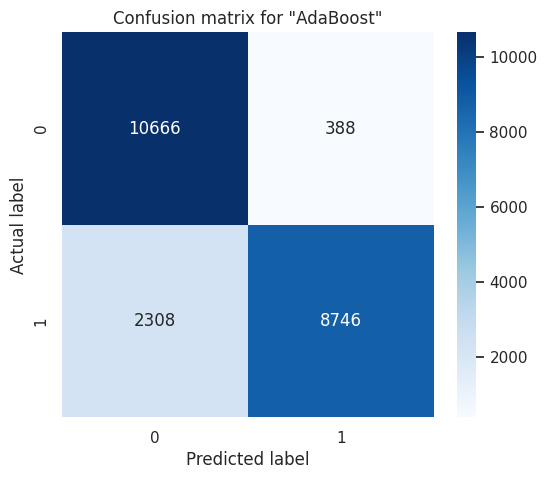

In [ ]:
# Present the confusion matrix for each model:
for name, metrics in cumulative_metrics.items():
    # Take the average confusion matrix across folds
    avg_cm = np.mean(metrics['Confusion Matrix'], axis=0).astype(int)
    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix for "{name}"')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    print(f'')